In [ ]:
import numpy as np
import pandas as pd
import math
import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from warnings import simplefilter
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(12, 6),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

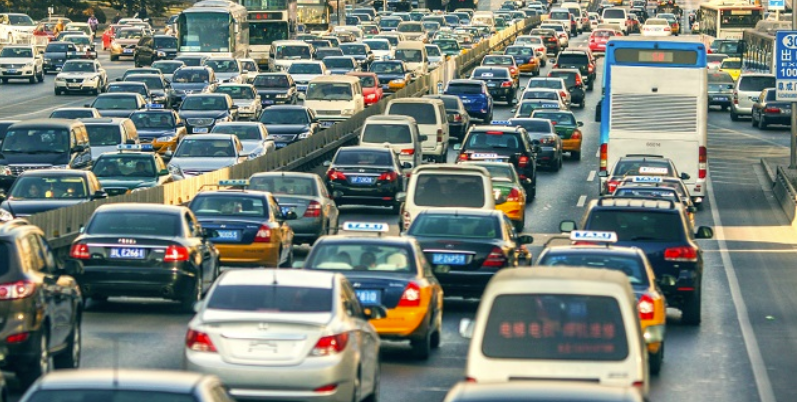

# Read the data

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col="row_id")
test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col="row_id")

### Train to test ratio

In [ ]:
k = train.shape[0] / test.shape[0]
k

### No missing values

In [ ]:
train_missing_values_count = train.isnull().sum()
test_missing_values_count  = test.isnull().sum()
train_missing_values_count, test_missing_values_count

### Unique time values in train and test

In [ ]:
train_time_unique_value_count = len(train['time'].unique().tolist())
test_time_unique_value_count  = len(test['time'].unique().tolist())
train_time_unique_value_count, test_time_unique_value_count, train_time_unique_value_count / test_time_unique_value_count

# Directions
* we have eight

In [ ]:
directions = train['direction'].unique().tolist()
degree = {'EB':180, 'NB':90, 'SB':270, 'WB':0, 'NE':135, 'SW':315, 'NW': 45, 'SE':225}

### Count values by direction

In [ ]:
dirs = pd.DataFrame(train['direction'].value_counts())
dirs['degree'] = list(degree.values())
dirs = dirs.rename(columns={'direction':'train'})
dirs['test'] = test['direction'].value_counts()
dirs = dirs.sort_values(by='degree')
dirs['rad'] = math.pi * dirs['degree'] / 180
dirs = dirs[['degree', 'rad', 'train', 'test']]
dirs

### Add directions in degrees and radians to train and test

In [ ]:
tmp = dirs[['degree', 'rad']].reset_index().rename(columns={'index':'direction'})
train = pd.merge(train, tmp, on='direction', how='left')
test = pd.merge(test, tmp, on='direction', how='left')

### Plot direction distributions in train and test

In [ ]:
fig = plt.figure(figsize=(15, 5))

r1 = dirs['train'].tolist()
r2 = (dirs['test'] * k).tolist()
theta = dirs['rad'].tolist()
r1 += [r1[0]]
r2 += [r2[0]]
theta += [theta[0]]

ax = fig.add_subplot(131, projection='polar')
ax.plot(theta, r1, c='r')
ax.set_title('Directions distribution in TRAIN')

ax = fig.add_subplot(132, projection='polar')
ax.plot(theta, r2, c='b')
ax.set_title('Directions distribution in TEST')

ax = fig.add_subplot(133, projection='polar')
ax.plot(theta, r1, c='r')
ax.plot(theta, r2, c='b')
ax.set_title('Distributions are equal')


### Count values in train and test by x & y

In [ ]:
coords = pd.DataFrame()
coords['train_x'] = train['x'].value_counts()
coords['train_y'] = train['y'].value_counts()
coords['test_x'] = test['x'].value_counts()
coords['test_y'] = test['y'].value_counts()
coords['test_kx'] = (test['x'].value_counts() * k).astype(int)
coords['test_ky'] = (test['y'].value_counts() * k).astype(int)

coords

* Once again the distributions are equal

### Combain x and y into loocation feature

In [ ]:
train['location'] = train['x'].astype(str) + train['y'].astype(str)
test['location']  = test['x'].astype(str) + test['y'].astype(str)

locs = pd.DataFrame()
locs['train'] = train['location'].value_counts()
locs['test'] = test['location'].value_counts()
locs['test_k'] = (test['location'].value_counts() * k).astype(int)
locs

In [ ]:
locations = locs.index.tolist() #.sort()
locations.sort()
locations

### Plot direction distribution for each location

In [ ]:
df = pd.DataFrame(degree.values(), index=list(degree.keys())).rename(columns={0:'degree'}).sort_values(by='degree')
df['rad'] = math.pi * df['degree'] / 180

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 12), subplot_kw=dict(projection='polar'))

for ax, lc in zip(axs.flat, locations):
    trn = train[train['location'] == lc]
    tst = test[test['location'] == lc]
    dtrn = pd.DataFrame(trn['direction'].value_counts()).rename(columns={'direction':'train'})
    dtst = pd.DataFrame(tst['direction'].value_counts()).rename(columns={'direction':'test'})
    drs = df.copy()
    drs = drs.join(dtrn).fillna(0)
    drs = drs.join(dtst).fillna(0)

    r1 = drs['train'].tolist()
    r2 = (drs['test'] * k).tolist()
    theta = drs['rad'].tolist()
    r1 += [r1[0]]
    r2 += [r2[0]]
    theta += [theta[0]]

    ax.plot(theta, r1, c='r')
    ax.plot(theta, r2, c='b')
    ax.set_title(lc)
plt.tight_layout()
plt.show()

* There is no difference between train and test in all locations. In all locations, but "00", distributions are symmetrical.

# Target

In [ ]:
target = 'congestion'

### Target distribution
* It's close to normal

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax = sns.distplot(train[target], label=target)
m, s = train[target].mean(), train[target].std()
n = np.random.normal(loc=m, scale=s, size=(100, 100))
ax = sns.distplot(n, hist=False, label='normal')
ax.legend()

### Target distributions by location

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))
for ax, lc in zip(axs.flat, locations):
    trn = train[train['location'] == lc]
    sns.distplot(train[target], ax=ax)
    ax.set_title(lc)
plt.tight_layout()
plt.show()    

### Target means by direction for locations
* no symmetry

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 12), subplot_kw=dict(projection='polar'))

for ax, lc in zip(axs.flat, locations):
    trn = train[train['location'] == lc]
    dtrn = pd.DataFrame(trn.groupby(['direction']).congestion.mean())
    drs = df.copy()
    drs = drs.join(dtrn).fillna(0)

    r = drs[target].tolist()
    theta = drs['rad'].tolist()
    r += [r[0]]
    theta += [theta[0]]

    ax.plot(theta, r, c='r')
    ax.set_title(lc)
plt.tight_layout()
plt.show()

# Time

In [ ]:
train['date'] = pd.to_datetime(train['time'])
train_date_min = train['date'].min()
print('train_date_min', train_date_min)
train_date_max = train['date'].max()
print('train_date_max', train_date_max)
train_date_unique = train['date'].unique()
step = train_date_unique[1] - train_date_unique[0]
print('step', step)
print('train dates count', len(list(train_date_unique)))
print('total periods between min and max date', 1 + (train_date_max - train_date_min) / step)

* 81 periods are missing in train

In [ ]:
test['date'] = pd.to_datetime(test['time'])
test_date_min = test['date'].min()
print('test_date_min', test_date_min)
test_date_max = test['date'].max()
print('test_date_max', test_date_max)
test_date_unique = test['date'].unique()
step = test_date_unique[1] - test_date_unique[0]
print('step', step)
print('test dates count', len(list(test_date_unique)))
print('total periods between min and max date', 1 + (test_date_max - test_date_min) / step)

### Add date and time features

In [ ]:
def add_datetime_features(df):
    df['month']   = df['date'].dt.month
    df['day']     = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df['weekend'] = (df['date'].dt.weekday >= 5)
    df['hour']    = df['date'].dt.hour
    df['minute']  = df['date'].dt.minute
    
    # number of 20' period in a day
    df['moment']  = df['date'].dt.hour * 3 + df['date'].dt.minute // 20   

In [ ]:
add_datetime_features(train)
add_datetime_features(test)
train

### Number samples with the same datetime

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
train['num'] = le.fit_transform(train['date'])
test['num'] = le.fit_transform(test['date'])

### Train target by direction for locations on the first "time"

In [ ]:
one_num = train[train['num'] == 0]
for lc in locations:
    sample = one_num[one_num.location == lc]
    display(sample[['location', 'direction', target]])

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 7), subplot_kw=dict(projection='polar'))

for ax, lc in zip(axs.flat, locations):
    sample = one_num[one_num['location'] == lc]
    dtrn = pd.DataFrame(sample.groupby(['direction']).congestion.mean())
    drs = df.copy()
    drs = drs.join(dtrn).fillna(0)

    r = drs[target].tolist()
    theta = drs['rad'].tolist()
    r += [r[0]]
    theta += [theta[0]]

    ax.plot(theta, r, c='r')
    ax.set_title(f'loc {lc}')
plt.tight_layout()
plt.show()

### Take one location point ans see how congestion changes by hour

In [ ]:
location = '21'
loc_train = train[train.location == location]
fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(20, 7), subplot_kw=dict(projection='polar'))

nums = [i*3 for i in range(24)]
for ax, num in zip(axs.flat, nums):
    sample = loc_train[loc_train['num'] == num]
    dtrn = pd.DataFrame(sample.groupby(['direction']).congestion.mean())
    drs = df.copy()
    drs = drs.join(dtrn).fillna(0)

    r = drs[target].tolist()
    theta = drs['rad'].tolist()
    r += [r[0]]
    theta += [theta[0]]

    ax.plot(theta, r, c='r')
    ax.set_title(f'hour {num//3}')
plt.tight_layout()
plt.show()    

### by day

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(20, 9), subplot_kw=dict(projection='polar'))

nums = [i*3*24 for i in range(30)]
for ax, num in zip(axs.flat, nums):
    sample = loc_train[loc_train['num'] == num]
    dtrn = pd.DataFrame(sample.groupby(['direction']).congestion.mean())
    drs = df.copy()
    drs = drs.join(dtrn).fillna(0)

    r = drs[target].tolist()
    theta = drs['rad'].tolist()
    r += [r[0]]
    theta += [theta[0]]

    ax.plot(theta, r, c='r')
    ax.set_title(f'day {num//72}')
plt.tight_layout()
plt.show()

# Animation
* Congestion in dynamic

In [ ]:
import plotly
import plotly.express as px
plotly.offline.init_notebook_mode (connected = True)

location = '21'
loc_train = train[train.location == location]

nums = list(loc_train['num'].unique())[:50]
anime = pd.DataFrame()
for num in nums:
    sample = loc_train[loc_train['num'] == num]
    dtrn = pd.DataFrame(sample.groupby(['direction']).congestion.mean())
    drs = df.copy()
    drs = drs.join(dtrn).fillna(0)
    drs['num'] = num
    anime = pd.concat([anime, drs], axis=0)

In [ ]:
px.line_polar(anime, r=target, theta="degree", line_close=True, animation_frame="num")

# Time series

### Looking for outliers

In [ ]:
the_date = pd.to_datetime('1991-09-02').dayofyear # Labor day

location = '11' # select to explore

location_train = train[train.location == location]
location_directions = list(location_train['direction'].unique())

for dir in location_directions:
    sample = location_train[location_train.direction == dir]
    sample['special'] = sample['date'].dt.dayofyear == the_date
    fig = px.scatter(sample, x='date', y='congestion', color='special', title=f'location {location}, direction {dir}') #
    fig.show()

### If you find the notebook interesting please consider to upvote.

# To be continued ...
* The next step is model selection